In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use("seaborn-v0_8")

In [26]:
sp500 = yf.download(
    "^GSPC",
    start="2010-01-01",
    auto_adjust=True
)
sp500.columns = sp500.columns.get_level_values(0)
sp500.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


In [27]:
sp500.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4036 entries, 2010-01-04 to 2026-01-20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   4036 non-null   float64
 1   High    4036 non-null   float64
 2   Low     4036 non-null   float64
 3   Open    4036 non-null   float64
 4   Volume  4036 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 189.2 KB


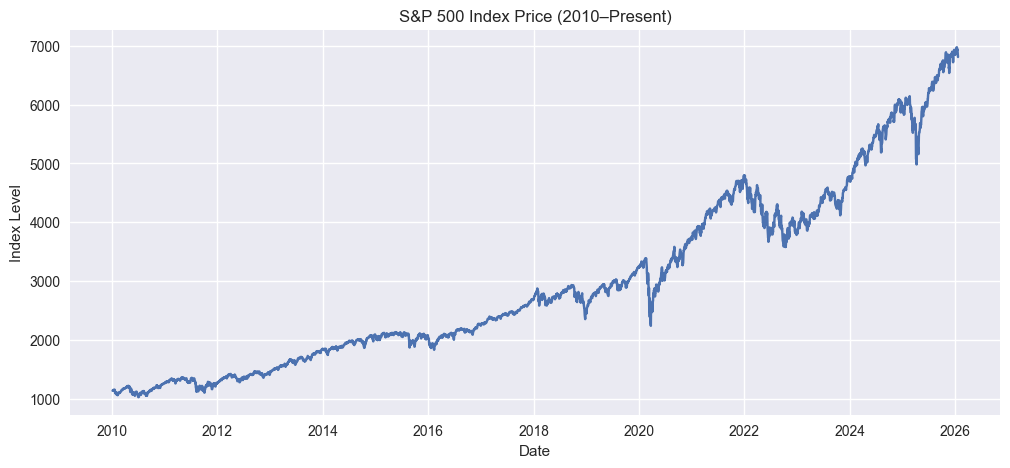

In [28]:
plt.figure(figsize=(12,5))
plt.plot(sp500.index, sp500["Close"])
plt.title("S&P 500 Index Price (2010–Present)")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.show()

In [29]:
sp500["log_return"] = np.log(
    sp500["Close"] / sp500["Close"].shift(1)
    )

sp500.dropna(inplace=True)

sp500.head()

Price,Close,High,Low,Open,Volume,log_return
Date,,,,,,
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,0.003111
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,0.000545
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,0.003993
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,0.002878
2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,0.001745


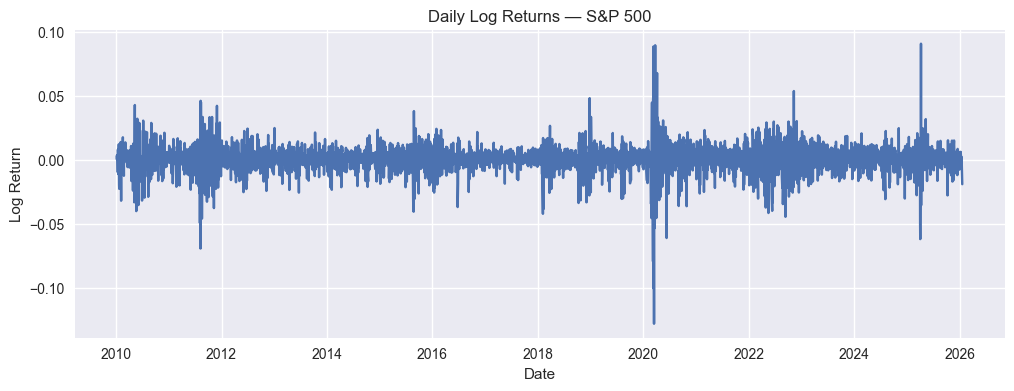

In [30]:
plt.figure(figsize=(12,4))
plt.plot(sp500.index, sp500["log_return"])
plt.title("Daily Log Returns — S&P 500")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

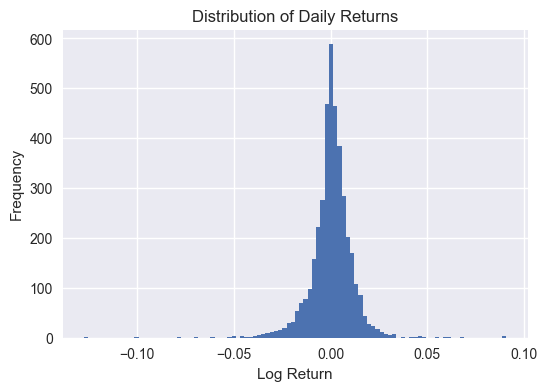

In [31]:
plt.figure(figsize=(6,4))
plt.hist(sp500["log_return"], bins=100)
plt.title("Distribution of Daily Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()

In [32]:
sp500['VOL20'] = sp500['log_return'].rolling(20).std() * np.sqrt(252)
sp500['VOL60'] = sp500['log_return'].rolling(60).std() * np.sqrt(252)

sp500[["VOL20", "VOL60"]].tail()

Price,VOL20,VOL60
Date,,
2026-01-13,0.085155,0.112810
2026-01-14,0.087669,0.113122
2026-01-15,0.087043,0.111280
2026-01-16,0.073428,0.111301
2026-01-20,0.099388,0.117511


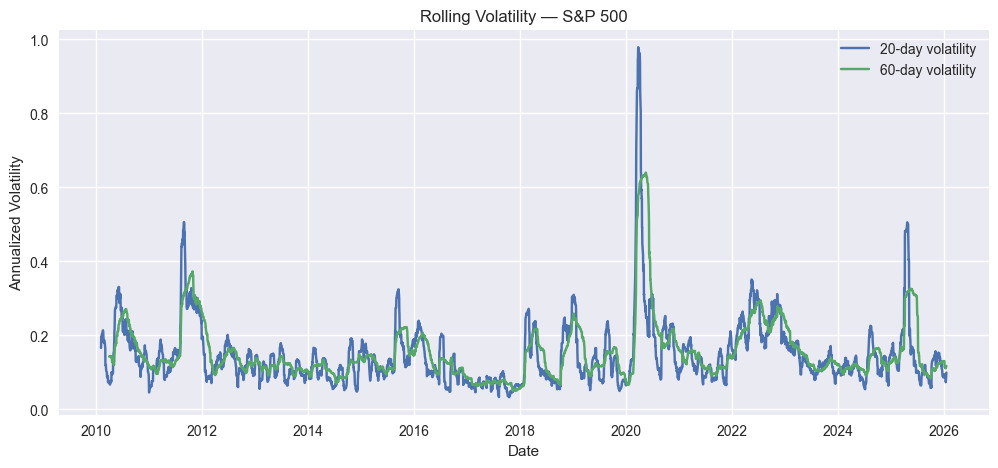

In [33]:
plt.figure(figsize=(12,5))
plt.plot(sp500.index, sp500["VOL20"], label="20-day volatility")
plt.plot(sp500.index, sp500["VOL60"], label="60-day volatility")
plt.title("Rolling Volatility — S&P 500")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.show()


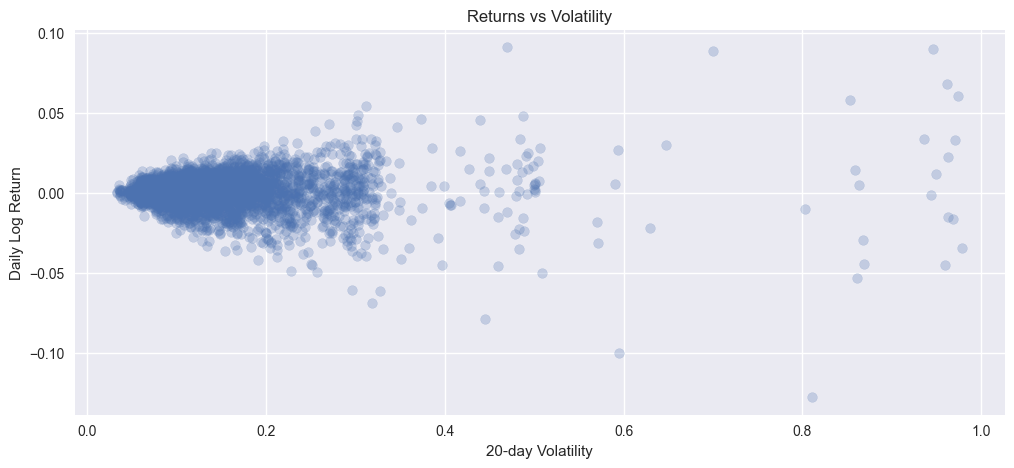

In [34]:
plt.figure(figsize=(12,5))
plt.scatter(
    sp500["VOL20"],
    sp500["log_return"],
    alpha=0.25
)
plt.xlabel("20-day Volatility")
plt.ylabel("Daily Log Return")
plt.title("Returns vs Volatility")
plt.show()


Rolling volatility exhibits strong persistence, with elevated risk levels remaining for extended periods following market shocks. While returns themselves show little predictability, volatility demonstrates clear regime behavior, increasing sharply during stress periods and decaying gradually afterward. The absence of a strong linear relationship between returns and volatility highlights the difficulty of short-term return forecasting despite observable risk dynamics.

In [35]:
sp500["ma_20"] = sp500["Close"].rolling(20).mean()
sp500["ma_50"] = sp500["Close"].rolling(50).mean()
sp500["ma_200"] = sp500["Close"].rolling(200).mean()

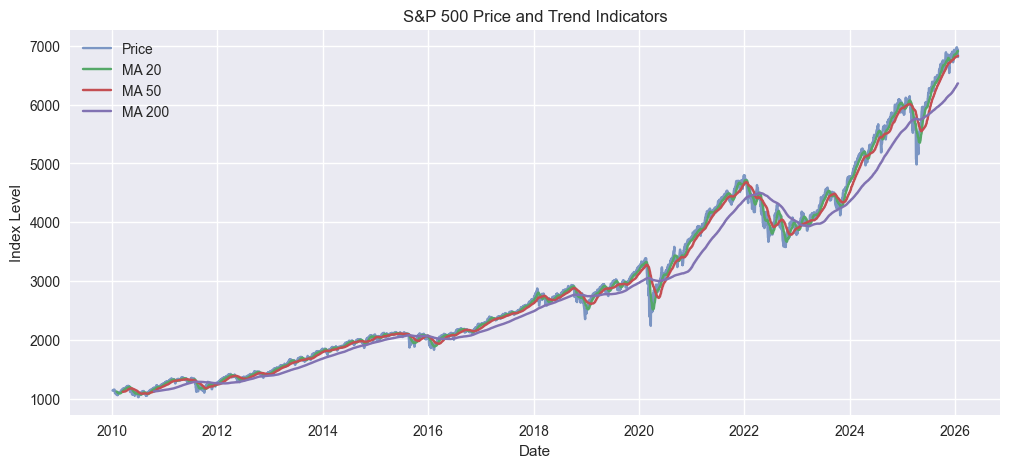

In [36]:
plt.figure(figsize=(12,5))
plt.plot(sp500.index, sp500["Close"], label="Price", alpha=0.7)
plt.plot(sp500.index, sp500["ma_20"], label="MA 20")
plt.plot(sp500.index, sp500["ma_50"], label="MA 50")
plt.plot(sp500.index, sp500["ma_200"], label="MA 200")
plt.title("S&P 500 Price and Trend Indicators")
plt.xlabel("Date")
plt.ylabel("Index Level")
plt.legend()
plt.show()


In [37]:
sp500["momentum_10"] = sp500["Close"] / sp500["Close"].shift(10) - 1
sp500["momentum_20"] = sp500["Close"] / sp500["Close"].shift(20) - 1

In [38]:
sp500["ma_distance"] = sp500["Close"] / sp500["ma_50"] - 1


In [40]:
sp500["target"] = (sp500["log_return"].shift(-1) > 0).astype(int)
sp500.dropna(inplace=True)


In [42]:
features = [
    "log_return",
    "VOL20",
    "VOL60",
    "momentum_10",
    "momentum_20",
    "ma_distance"
]

X = sp500[features]
y = sp500["target"]


In [43]:
split = int(len(sp500) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
